In [56]:
import gymnasium as gym
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib qt
import torch

RENDER_HUMAN = False
if RENDER_HUMAN:
    env = gym.make('CartPole-v1', render_mode="human")
else:
    env = gym.make('CartPole-v1')

print("Action Space: ", env.action_space)
print("Obs Space: ", env.observation_space)


SEED = 0
torch.manual_seed(SEED)


Action Space:  Discrete(2)
Obs Space:  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In [121]:
# Initalize Agent Brain

HISTORY_LEN = 2

W = torch.normal(0,1,size=(4*HISTORY_LEN,4), requires_grad=True)

H = torch.zeros(size=(HISTORY_LEN,4))
# see https://stackoverflow.com/questions/51761806/is-it-possible-to-create-a-fifo-queue-with-pytorch
# Predict next obs, reward, terminal, and also take an action

L = torch.zeros(size=(100,))
print(L.shape)

torch.Size([100])


In [122]:
observation, info = env.reset(seed=SEED)

for _ in range(1000):

    if RENDER_HUMAN:
        env.render()    

    # forward pass - make prediction
    x = H.reshape(1, -1)
    y =  x @ W
    
    #world time step
    action = env.action_space.sample()  # agent policy that uses the observation and info
    # action = 0
    observation, reward, terminated, truncated, info = env.step(action)
    obs = torch.tensor(observation).reshape(1,4)
    #calculate prediction error
    loss = torch.abs(obs - y).mean()

    #backward pass
    W.grad = None
    loss.backward()
    W.data += -0.1 * W.grad

    # print(loss.item())
    # update history
    H = torch.cat((H[1:], obs))
    L = torch.cat((L[1:], torch.tensor([loss])))
    print("Avg loss: ", L.mean().item())


    # print(observation, reward, terminated, truncated, info)
    if terminated or truncated:
        observation, info = env.reset(seed=SEED)

env.close()

#History - Avg loss 
#1 - 0.146
#2 -  0.176
#3 - 0.18


Avg loss:  0.0012676708865910769
Avg loss:  0.004193214699625969
Avg loss:  0.008590970188379288
Avg loss:  0.013727269135415554
Avg loss:  0.017399849370121956
Avg loss:  0.023577680811285973
Avg loss:  0.02961064875125885
Avg loss:  0.03582983836531639
Avg loss:  0.042059365659952164
Avg loss:  0.0482274666428566
Avg loss:  0.05346375331282616
Avg loss:  0.058555591851472855
Avg loss:  0.06352588534355164
Avg loss:  0.06789115816354752
Avg loss:  0.07470933347940445
Avg loss:  0.08131925761699677
Avg loss:  0.08426538109779358
Avg loss:  0.09052543342113495
Avg loss:  0.09548112004995346
Avg loss:  0.10045181214809418
Avg loss:  0.10498534888029099
Avg loss:  0.10975843667984009
Avg loss:  0.11807949841022491
Avg loss:  0.12513288855552673
Avg loss:  0.13471895456314087
Avg loss:  0.1477530598640442
Avg loss:  0.1641959249973297
Avg loss:  0.18103599548339844
Avg loss:  0.18589209020137787
Avg loss:  0.18986967206001282
Avg loss:  0.19421228766441345
Avg loss:  0.19999034702777863
Av

In [123]:


observation, info = env.reset(seed=SEED)
actual_obs = [[] for _ in range(4)]
pred_obs = [[] for _ in range(4)]
random_pred_obs = [[] for _ in range(4)]
W_random = torch.normal(0,1,size=(8,4), requires_grad=True)

for _ in range(100):

    x = H.reshape(1, 8)
    y =  x @ W
    y_random =  x @ W_random

    action = env.action_space.sample()  # agent policy that uses the observation and info
    # action = 0
    observation, reward, terminated, truncated, info = env.step(action)
    obs = torch.tensor(observation).reshape(1,4)

    # Update actual and predicted observations
    for i in range(4):
        actual_obs[i].append(obs[0, i].item())
        pred_obs[i].append(y[0, i].item())
        random_pred_obs[i].append(y_random[0, i].item())

    H = torch.cat((H[1:], obs))

    if terminated or truncated:
        observation, info = env.reset(seed=SEED)

env.close()


RuntimeError: shape '[1, 8]' is invalid for input of size 12

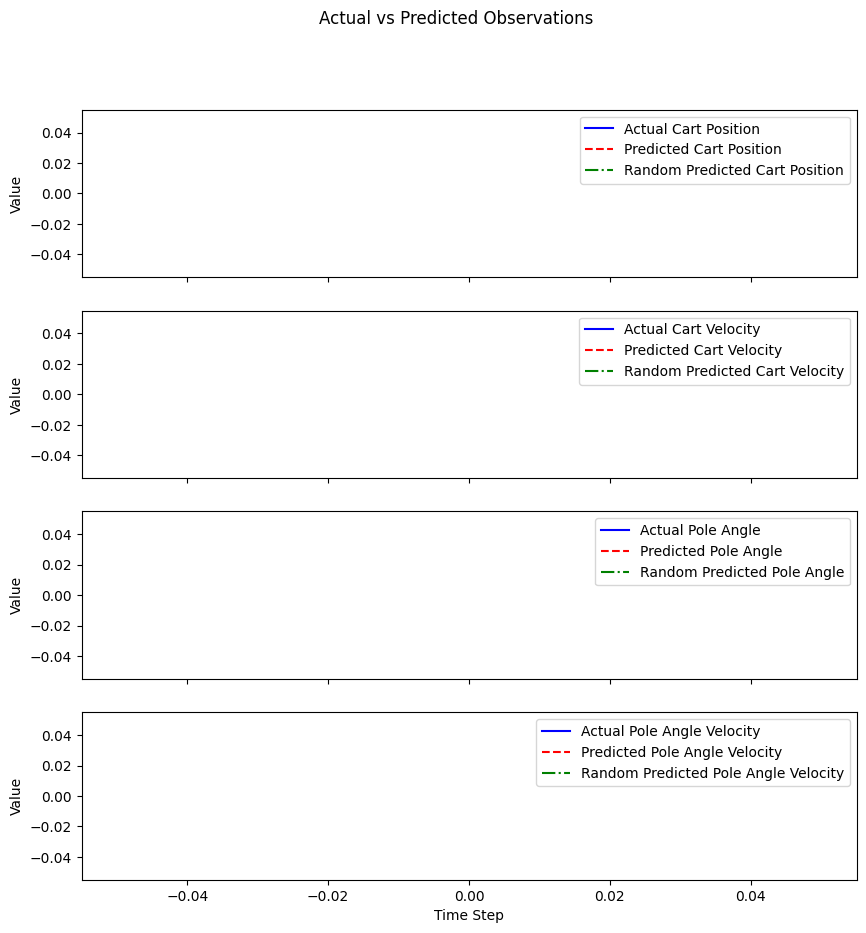

In [124]:
# Create subplots for each set of predicted and actual values
fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

legend_labels = {
    1: 'Cart Position',
    2: 'Cart Velocity',
    3: 'Pole Angle',
    4: 'Pole Angle Velocity'
}

# Plot actual and predicted values for each set
for i in range(4):
    axs[i].plot(actual_obs[i], color='blue', linestyle='-', label=f'Actual {legend_labels[i+1]}')
    axs[i].plot(pred_obs[i], color='red', linestyle='--', label=f'Predicted {legend_labels[i+1]}')
    axs[i].plot(random_pred_obs[i], color='green', linestyle='-.', label=f'Random Predicted {legend_labels[i+1]}')
    axs[i].set_ylabel('Value')
    axs[i].legend()

# Add labels and title
axs[-1].set_xlabel('Time Step')
plt.suptitle('Actual vs Predicted Observations')

# Show the plot
plt.show()